In [1]:
import re
import sys
import itertools
import numpy as np
import multiprocessing
from numpy.linalg import norm
from typing import List, Union
from scipy.optimize import minimize
from scipy.sparse import csr_matrix
from scipy.stats import unitary_group
from utils import su2_encoding, CDTYPE
from IPython.display import display_svg
from mindquantum.simulator import Simulator
from mindquantum.core.circuit import Circuit
from mindquantum.core.operators import Hamiltonian
from mindquantum.simulator.utils import GradOpsWrapper
from mindquantum.core.gates import X, Y, Z, RX, RY, RZ, UnivMathGate


def add_gate(gate_str: str, t: Union[float, str] = 1):
    pattern = '([A-Za-z]+)(\d+)'
    gate = re.search(pattern, gate_str).group(1)
    site = re.search(pattern, gate_str).group(2)
    ctrl = int(site[1]) if len(site) > 1 else []
    obj = int(site[0])
    circ = Circuit()
    if gate == 'X':
        circ += X(obj)
    elif gate == 'Y':
        circ += Y(obj)
    elif gate == 'Z':
        circ += Z(obj)
    elif gate == 'CX':
        circ += X(obj, ctrl)
    elif gate == 'CY':
        circ += Y(obj, ctrl)
    elif gate == 'CZ':
        circ += Z(obj, ctrl)
    elif gate == 'RX':
        circ += RX(t).on(obj, ctrl)
    elif gate == 'RY':
        circ += RY(t).on(obj, ctrl)
    elif gate == 'RZ':
        circ += RZ(t).on(obj, ctrl)
    elif gate == 'XRYX':
        circ += X(ctrl, obj)
        circ += RY(t).on(obj, ctrl)
        circ += X(ctrl, obj)
    else:
        raise ValueError(f'Wrong input gate: {gate}')
    return circ


def training(gate: np.ndarray, ansatz: Circuit):

    def optimization(init_params: np.ndarray, sim_grad: GradOpsWrapper, loss_list: List[float] = None):
        f, g = sim_grad(init_params)
        loss = 1 - np.real(f)[0][0]
        grad = -np.real(g)[0][0]
        if loss_list is not None:
            loss_list.append(loss)
        return loss, grad

    def callback(curr_params: np.ndarray, tol: float = 1e-8):
        f, _ = sim_grad(curr_params)
        loss = 1 - np.real(f)[0][0]
        if loss < tol:
            raise StopIteration

    circ = Circuit() + UnivMathGate('Up', gate).on(obj)
    psi_rand = np.random.rand(2**nq) + 1j * np.random.rand(2**nq)
    sim = Simulator('mqvector', nq)
    sim.set_qs(psi_rand)
    sim.apply_circuit(circ)
    psi = sim.get_qs()
    rho = np.outer(psi, psi.conj())
    Ham = Hamiltonian(csr_matrix(rho))

    p_name = ansatz.ansatz_params_name
    p_num = len(p_name)

    sim.reset()
    sim.set_qs(psi_rand)
    sim_grad = sim.get_expectation_with_grad(Ham, ansatz)
    init_params = np.random.uniform(-np.pi, np.pi, p_num)

    res = minimize(optimization, init_params, args=(sim_grad, []), \
        method='BFGS', jac=True, callback=callback, options={'gtol': 1e-12})
    fidelity = 1 - res.fun
    pr_res = dict(zip(p_name, res.x))
    ansatz = ansatz.apply_value(pr_res)

    if p_num <= para_num and res.fun < 1e-8:
        print(res.message, pr_res)
        print(f'Optimal: {res.fun}, Fidelity: {fidelity:.20f}')
        display_svg(ansatz.svg())


def gate_ind(dim: int, ind: List[int], gate_list: List[str]) -> List[str]:
    global nq, obj, U, Up
    nq = dim - 1
    obj = list(range(nq))
    U = unitary_group.rvs(2, random_state=42)
    Ud = np.eye(dim, dtype=CDTYPE)
    Ud[np.ix_(ind, ind)] = U

    p = np.eye(2**(dim - 1)) - su2_encoding(np.eye(dim))
    Ue = su2_encoding(Ud)
    Up = Ue + p

    obj_perm = list(itertools.permutations(obj, 2))
    obj_comb = list(itertools.combinations(obj, 2))

    gate_site = []
    for g in gate_list:
        if g in ['X', 'Y', 'Z']:
            for s in obj:
                gate_site.append(f'{g}{s}')
        elif g in ['CX', 'CY', 'CZ']:
            for s in obj_perm:
                gate_site.append(f'{g}{s[0]}{s[1]}')
        elif g in ['RX', 'RY', 'RZ']:
            for s in obj:
                gate_site.append(f'{g}{s}')
            for s in obj_perm:
                gate_site.append(f'{g}{s[0]}{s[1]}')
        elif g == 'XRYX':
            for s in obj_comb:
                gate_site.append(f'{g}{s[0]}{s[1]}')
        else:
            raise ValueError(f'Wrong input gate: {g}')
    gate_site = list(dict.fromkeys(gate_site))
    return gate_site


def circuit(gate_tuple: tuple):
    circ = Circuit()
    corr = Circuit()
    for i, g in enumerate(gate_tuple):
        corr += add_gate(g, f'{g}_{i}')
    circ += corr
    circ += UnivMathGate('U', U).on(obj[0], obj[1:])
    circ += corr.hermitian()
    if len(circ.ansatz_params_name) > 0:
        training(Up, circ)


def parallel(dim: int, ind: List[int], gate_list: List[str], gate_num: int, pool_size: int = 32):
    gate_sites = gate_ind(dim, ind, gate_list)
    print(dim, ind, gate_list, gate_sites)

    if pool_size == 0 and sys.platform.startswith('win'):
        for gate_tuple in itertools.product(gate_sites, repeat=gate_num):
            circuit(gate_tuple)
    else:
        pool = multiprocessing.Pool(pool_size)
        for gate_tuple in itertools.product(gate_sites, repeat=gate_num):
            pool.apply_async(circuit, (gate_tuple, ))
        pool.close()
        pool.join()


dim = 4
ind = [0, 1]
gate_num = 3
para_num = 10
# gate_list = ['X', 'XRYX']
gate_list = ['X', 'CX', 'RY']
# gate_list = ['X', 'Y', 'Z', 'CX', 'CY', 'CZ', 'RX', 'RY', 'RZ']
parallel(dim, ind, gate_list, gate_num)

4 [0, 1] ['X', 'CX', 'RY'] ['X0', 'X1', 'X2', 'CX01', 'CX02', 'CX10', 'CX12', 'CX20', 'CX21', 'RY0', 'RY1', 'RY2', 'RY01', 'RY02', 'RY10', 'RY12', 'RY20', 'RY21']


3 [0, 1] ['X', 'CX', 'RY'] ['X0', 'X1', 'CX01', 'CX10', 'RY0', 'RY1', 'RY01', 'RY10']
`callback` raised `StopIteration`. {'RY10_2': 1.5707961998549265}
Optimal: 1.7763568394002505e-15, Fidelity: 0.99999999999999822364


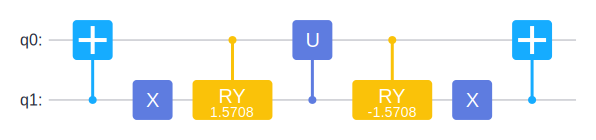

`callback` raised `StopIteration`. {'RY10_1': -1.5708292999204174}
Optimal: 1.733135857051593e-11, Fidelity: 0.99999999998266864143


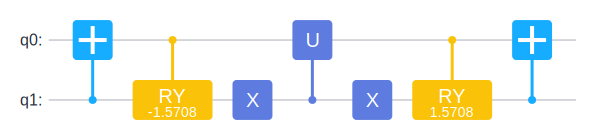

3 [0, 2] ['X', 'CX', 'RY'] ['X0', 'X1', 'CX01', 'CX10', 'RY0', 'RY1', 'RY01', 'RY10']
`callback` raised `StopIteration`. {'RY10_1': 3.141847673472732}
Optimal: 9.214691454317858e-09, Fidelity: 0.99999999078530854568


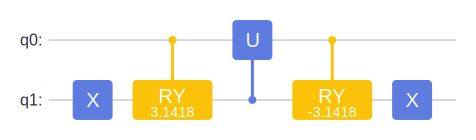

`callback` raised `StopIteration`. {'RY1_1': 3.141634226251163}
Optimal: 3.9359371317715386e-10, Fidelity: 0.99999999960640628682


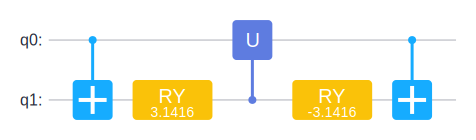

3 [1, 2] ['X', 'CX', 'RY'] ['X0', 'X1', 'CX01', 'CX10', 'RY0', 'RY1', 'RY01', 'RY10']
`callback` raised `StopIteration`. {'RY10_1': 1.5707944106621161}
Optimal: 8.740785872873857e-13, Fidelity: 0.99999999999912592141


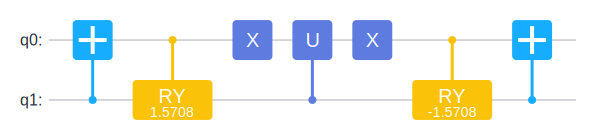

`callback` raised `StopIteration`. {'RY10_1': 1.5707962623493334}
Optimal: 1.5543122344752192e-15, Fidelity: 0.99999999999999844569


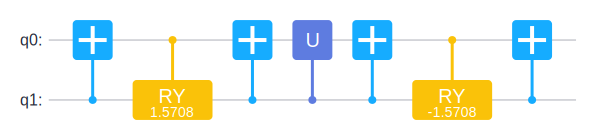

`callback` raised `StopIteration`. {'RY01_1': -1.5708168733222083}
Optimal: 1.0305978292990403e-10, Fidelity: 0.99999999989694021707


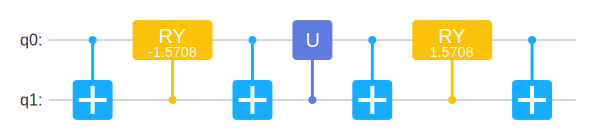

In [2]:
dim = 3
para_num = 1
gate_list = ['X', 'CX', 'RY']
parallel(dim, [0, 1], gate_list, gate_num=3, pool_size=0)
parallel(dim, [0, 2], gate_list, gate_num=2, pool_size=0)
parallel(dim, [1, 2], gate_list, gate_num=3, pool_size=0)